<a href="https://colab.research.google.com/github/kandgesid/Data-Science-and-ML-projects/blob/master/NST_using__TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import functools
import IPython.display as display

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_image_path = '/content/content_image.jpg'
style_image_path = '/content/style_image2.jpg'

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def display_img(img, title=None):
  if len(img.shape) > 3:
    image = tf.squeeze(img, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

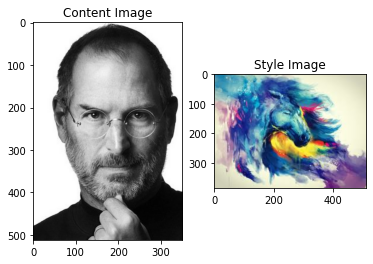

In [ ]:
content_image = load_img(content_image_path)

style_image = load_img(style_image_path)

plt.subplot(1, 2, 1)
display_img(content_image, 'Content Image')

plt.subplot(1, 2, 2)
display_img(style_image, 'Style Image')

In [ ]:
content_image.shape

TensorShape([1, 512, 351, 3])

Here we are going to use pretrained VGG19 model as mentioned in [original NST paper](https://arxiv.org/abs/1508.06576)  

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
  print(layer.name)

input_19
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def custom_model(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.models.Model([vgg.inputs], outputs)
  return model

In [ ]:
def gram_matrix(input_tensor):
    
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:

#output shape is correct but something is going wrong.
'''
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze(temp)
  print(temp.shape)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = tf.matmul(fun, fun, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  print('/n')
  print(gram.shape)
  return gram'''

"\ndef gram_matrix(tensor):\n  temp = tensor\n  temp = tf.squeeze(temp)\n  print(temp.shape)\n  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])\n  result = tf.matmul(fun, fun, transpose_b=True)\n  gram = tf.expand_dims(result, axis=0)\n  print('/n')\n  print(gram.shape)\n  return gram"

In [ ]:
class style_content_model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(style_content_model, self).__init__()
    self.model = custom_model(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.model.trainable = False
  
  def call(self, inputs):
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.model(preprocessed_input)

    style_outputs, content_outputs = (outputs[:num_style_layers], outputs[num_style_layers:])

    style_outputs = [gram_matrix(output) for output in style_outputs]

    style_dict = {style_name : value for style_name, value in zip(self.style_layers, style_outputs)}

    content_dict = {content_name : value for content_name, value in zip(self.content_layers, content_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = style_content_model(style_layers, content_layers)

style_image_features = extractor(style_image)['style']

content_image_features = extractor(content_image)['content']

In [ ]:
# Custom weights for style and content updates
style_weight=1e-2
content_weight=1e4

# Custom weights for different style layers
style_weights = {'block1_conv1': 0.2,
                 'block2_conv1': 0.2,
                 'block3_conv1': 0.2,
                 'block4_conv1': 0.2,
                 'block5_conv1': 0.2}

In [ ]:
def total_loss(generated_img_dict):
  style_outputs_for_generated_img = generated_img_dict['style']
  content_outputs_for_generated_img = generated_img_dict['content']
  #content loss and normalize it
  content_loss = tf.add_n([tf.reduce_mean((content_image_features[name] - content_outputs_for_generated_img[name]) ** 2) for name in content_outputs_for_generated_img.keys()])

  content_loss *= content_weight / num_content_layers
  
  #style loss and normalize it
  style_loss = tf.add_n([style_weights[name] * tf.reduce_mean((style_image_features[name] - style_outputs_for_generated_img[name]) ** 2) for name in style_outputs_for_generated_img.keys()])

  style_loss *= style_weight / num_style_layers

  total_loss = style_loss + content_loss

  return total_loss

In [ ]:
m, h, w, c = content_image.shape
noise_ratio = 0.6

In [ ]:
#noise_image = np.random.uniform(-20, 20, (1, h, w, c)).astype('float32')
# Set the input_image to be a weighted average of the content_image and a noise_image
#generated_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)

In [ ]:
generated_image = tf.Variable(content_image)
generated_image.shape

TensorShape([1, 512, 351, 3])

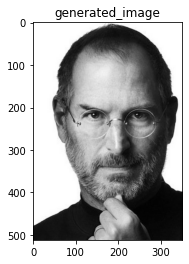

In [ ]:
display_img(generated_image, 'generated_image')

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    # Extract the features
    outputs = extractor(image)
    # Calculate the loss
    loss = total_loss(outputs)
  # Determine the gradients of the loss function w.r.t the image pixels
  grad = tape.gradient(loss, image)
  # Update the pixels
  opt.apply_gradients([(grad, image)])
  # Clip the pixel values that fall outside the range of [0,1]
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

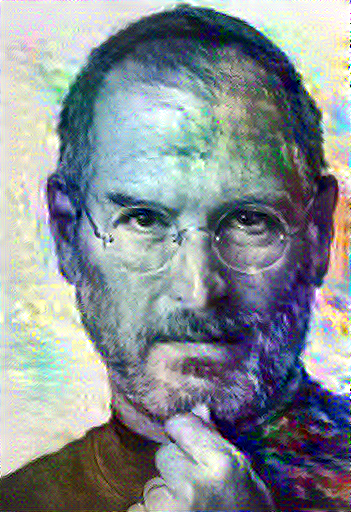

Train step: 1000


In [ ]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(generated_image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(generated_image))
  print("Train step: {}".format(step))

Total variational loss

In [ ]:
#This is a traditional methode to calculate a total variational loss. But in tf 2.0 there is in-built methode to caculate this loss
'''
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))
'''

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    # Extract the features
    outputs = extractor(image)
    # Calculate the loss
    loss = total_loss(outputs)
    #loss including total_variational loss using tf in-built function 
    loss += total_variation_weight*tf.image.total_variation(image)
  # Determine the gradients of the loss function w.r.t the image pixels
  grad = tape.gradient(loss, image)
  # Update the pixels
  opt.apply_gradients([(grad, image)])
  # Clip the pixel values that fall outside the range of [0,1]
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [ ]:
generated_image = tf.Variable(content_image)
generated_image.shape

TensorShape([1, 512, 351, 3])

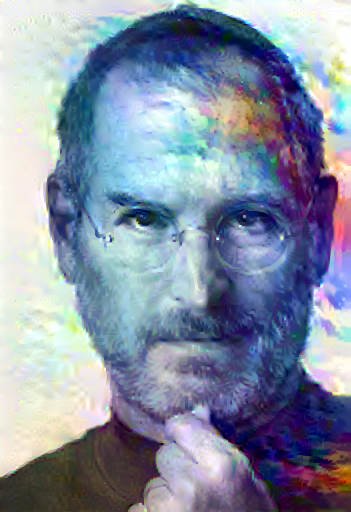

Train step: 1000


In [ ]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(generated_image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(generated_image))
  print("Train step: {}".format(step))

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(generated_image).save(file_name)